In [1]:

import random
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [2]:

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
from torchinfo import summary

In [3]:
def seed_everything(seed=2024):
    import random
    import os
    import numpy as np
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

In [4]:
def load_data(path_to_data: str):
    data = pd.read_csv(path_to_data)
    return data

## 1. Regression Model

The following code block constructs two regression models to predict the salaries of baseball players using the Hitters Dataset (from the ISLR Book). Find what is missing and complete it.

In [6]:
hitters = load_data(path_to_data='data/hitters.csv').dropna()
hitters = pd.get_dummies(hitters, columns=['League', 'Division', 'NewLeague'], drop_first=True)
hitters = hitters.drop('Names', axis=1)

X = hitters.drop('Salary', axis=1).to_numpy()
y = hitters['Salary'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024) #This disappears

linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearRegression())
])

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', Lasso())
])


linear_pipeline.fit(X_train, y_train)
lasso_pipeline.fit(X_train, y_train)

linear_pred = linear_pipeline.predict(X_test)
lasso_pred = lasso_pipeline.predict(X_test)

linear_mae = mean_absolute_error(y_test, linear_pred)
lasso_mae = mean_absolute_error(y_test, lasso_pred)
print(f'Linear MAE: {linear_mae}, Lasso MAE: {lasso_mae}')


Linear MAE: 198.3418263757652, Lasso MAE: 199.18428092561692


## 2. Dataset in Pytorch

The cell below is for converting our **training and testing data into PyTorch tensors** and then creating a `TensorDataset` for each of them.

- `X_train_tensor = torch.tensor(X_train.astype(np.float32))` and `y_train_tensor = torch.tensor(y_train.astype(np.float32))`: These lines convert the training data (`X_train`) and labels (`y_train`) into PyTorch tensors. The `astype(np.float32)` part is used to ensure that the data is in the `float32` format, which is a requirement for many PyTorch functions.

- `hit_traindataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)`: This line creates a `TensorDataset` from the training data and labels. A `TensorDataset` is a dataset provided by PyTorch that wraps tensors. Each sample will be retrieved by indexing tensors along the first dimension.

The next two lines do the same for the **testing data (`X_test`) and labels (`y_test`)**.

See how the data are organized : `hit_traindataset[0]`

In [7]:
X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32))

hit_traindataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)

X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.float32))

hit_testdataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

The cell below creates `DataLoader` objects for both the training and testing datasets. These DataLoader objects will be used to iterate over the datasets in batches during the training and testing phases of the model. This allows for more efficient use of memory and can make training faster, especially for large datasets. The DataLoader also handles the shuffling of the data, which helps ensure that the model doesn't learn any unintended patterns from the order of the training data.

In [8]:
hit_trainloader = torch.utils.data.DataLoader(hit_traindataset, batch_size=32, shuffle=True)
hit_testloader = torch.utils.data.DataLoader(hit_testdataset, batch_size=32, shuffle=False)

We define new class named `HittersModel` which is a subclass of `nn.Module`. The `nn.Module` class is a fundamental class provided by PyTorch and is used to represent neural network models. 

In `__init__`, we define:

- `self.fc1 = nn.Linear(input_dim, 50)`: A fully connected layer with `input_dim` inputs and 50 outputs.
- `self.relu = nn.ReLU()`: The ReLU activation function.
- `self.dropout = nn.Dropout(0.4)`: A dropout layer with a rate of 0.4 for regularization.
- `self.fc2 = nn.Linear(50,1)`: Another fully connected layer with 50 inputs and 1 output for binary classification.

Additionally, the `__init__` method includes a call to `super().__init__()`. This function allows subclasses to access methods from their parent class. For instance, `nn.Module` has its own `__init__` method, which is different from the `__init__` method we've defined for `HittersModel`. By using `super().__init__()`, we're calling the `__init__` method of the parent class, ensuring that our model is correctly interpreted by PyTorch.


The `forward` method defines the forward pass of the neural network, which is how the network processes inputs.

Here's what each line does:

- `x = self.fc1(x)`: This line passes the input `x` through the first fully connected layer (`fc1`).

- `x = self.relu(x)`: This line applies the ReLU activation function to the output of the first fully connected layer. The ReLU function is defined as `ReLU(x) = max(0, x)`, which introduces non-linearity into the model.

- `x = self.dropout(x)`: This line applies dropout to the output of the ReLU function. Dropout randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting.

- `x = self.fc2(x)`: This line passes the output of the dropout layer through the second fully connected layer (`fc2`).

- `return x.squeeze()`: This line removes dimensions of size 1 from the output. For example, if the output shape was `(batch_size, 1)`, it becomes `(batch_size,)` after squeezing. This is often necessary because many loss functions expect the target and input to have the same dimensions.

In summary, the `forward` method takes an input tensor, passes it through two fully connected layers with a ReLU activation and dropout in between, and returns the output after squeezing unnecessary dimensions.


In [9]:
class HittersModel(nn.Module):
    def __init__(self, input_dim):
        super(HittersModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(50,1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()


## Training Loop

The `train_function` represents a standard training cycle for a PyTorch model. It iterates over the dataset multiple times (epochs) and calculates updates.

In [10]:
def train_function(model, train_loader, test_loader, epochs, optimizer, criterion):
    for epoch in range(epochs):
        model.train()
        epoch_tloss, epoch_vloss, epoch_vmetrics = 0., 0., 0.
        for X, y in train_loader: # X is the input and y is the target
            optimizer.zero_grad() # zero the parameter gradients
            output = model(X) 
            tloss = criterion(output, y)
            tloss.backward() # backpropagation
            optimizer.step() # update the weights
            epoch_tloss += tloss.item() # add the loss to the epoch loss
        model.eval()
        with torch.no_grad():
            for X, y in test_loader:
                output = model(X)
                vloss = criterion(output, y)
                mae = nn.functional.l1_loss(output, y) # mean absolute error
                epoch_vloss += vloss.item() 
                epoch_vmetrics += mae.item()
            print(f'Epoch: {epoch} : Train Loss: {epoch_tloss/len(train_loader):.2f} || Test Loss: {epoch_vloss/len(test_loader):.2f} || Test MAE: {epoch_vmetrics/len(test_loader):.2f}')

### Questions

1. What is the purpose of `model.train()` and `model.eval()`? What might go wrong if we forgot to call these functions?

The methods `model.train()` and `model.eval()` are used to set the model to training and evaluation modes, respectively. During training, we often use regularization techniques to prevent overfitting, but these are not typically used during evaluation. Setting the model to the appropriate mode enables or disables these functionalities as needed. If we forget to set the correct mode, for example, if we leave the model in evaluation mode during training, regularization will not be applied, and vice versa.


2. Why do we compute the loss on both the training data and the testing data? What is the difference between these two losses?

The loss on the training data is used to optimize the model parameters, whereas the loss on the test data is used for model evaluation.

3. Why do we use `with torch.no_grad():` during evaluation? What would happen if we didn't use it?

We use torch.no_grad() to disable the computation of gradients for the model's parameters, as we are only interested in computing the model's predictions, not the gradients. If we forget to use torch.no_grad(), PyTorch will still compute the gradients of the parameters. This is unnecessary and can lead to memory issues if the model size is too large.

#### You can run the cell below to train the model on Hitters dataset

In [12]:
model = HittersModel(input_dim=X_train.shape[1]) 
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_function(model, hit_trainloader, hit_testloader, 30, optimizer, criterion)

Epoch: 0 : Train Loss: 391144.94 || Test Loss: 224939.05 || Test MAE: 314.96
Epoch: 1 : Train Loss: 286116.53 || Test Loss: 160678.49 || Test MAE: 245.26
Epoch: 2 : Train Loss: 228130.98 || Test Loss: 126535.66 || Test MAE: 203.26
Epoch: 3 : Train Loss: 230816.93 || Test Loss: 114291.77 || Test MAE: 199.96
Epoch: 4 : Train Loss: 239676.77 || Test Loss: 111164.96 || Test MAE: 200.72
Epoch: 5 : Train Loss: 245105.29 || Test Loss: 109335.26 || Test MAE: 200.75
Epoch: 6 : Train Loss: 210939.00 || Test Loss: 109881.49 || Test MAE: 197.50
Epoch: 7 : Train Loss: 201295.06 || Test Loss: 110906.65 || Test MAE: 196.00
Epoch: 8 : Train Loss: 202527.03 || Test Loss: 110063.98 || Test MAE: 195.47
Epoch: 9 : Train Loss: 191433.71 || Test Loss: 110025.21 || Test MAE: 195.25
Epoch: 10 : Train Loss: 184020.50 || Test Loss: 108428.09 || Test MAE: 195.43
Epoch: 11 : Train Loss: 206570.91 || Test Loss: 105209.84 || Test MAE: 195.97
Epoch: 12 : Train Loss: 200147.48 || Test Loss: 103937.55 || Test MAE: 196

# 2. CNN with Pytorch 

In [13]:
from torchvision.io import read_image
from torchvision.datasets import FashionMNIST
from torchvision.transforms import (Compose,
                                    ToTensor, 
                                    Normalize,
                                    RandomHorizontalFlip, 
                                    RandomCrop)

### Load FashionMNIST data

In [14]:
(train_data,test_data )= [FashionMNIST(root="data", train=train, download=True, transform=ToTensor()) for train in [True, False]]
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [15]:
# Explore the dataset

print(f"Number of training examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")
print(f"Classes: {train_data.classes}")
print(f"Data dimension: {train_data.data.shape}")


Number of training examples: 60000
Number of test examples: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Data dimension: torch.Size([60000, 28, 28])


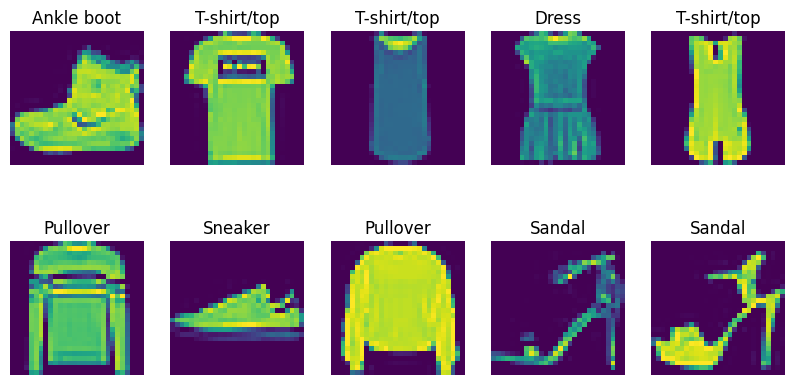

In [16]:
# Show the first 10 images
import matplotlib.pyplot as plt
classes_map = {idx:value for idx,value in zip(np.arange(len(train_data.classes)), train_data.classes)}
# Show the first 10 images
def show_image(data):
    fig = plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        im = data[i][0].permute(1,2,0).squeeze().numpy()
        plt.imshow(im)
        plt.title(classes_map[data[i][1]])
        plt.axis("off")
    plt.show()
show_image(train_data)


## Convolution 2D
The `Conv2d` function in PyTorch represents a 2-dimensional convolutional layer. Let's break down the parameters:

- `in_channels`: This parameter specifies the number of channels (or depth) in the input image or feature map. For example, if you're dealing with RGB images, `in_channels` would be 3 since there are three color channels (red, green, blue).

- `out_channels`: This parameter defines the number of filters (or kernels) in the convolutional layer. Each filter produces one channel in the output feature map. In your example, there will be 32 output channels.

- `kernel_size`: This parameter determines the size of the convolutional kernel. Here, it's set to `3`, indicating that each kernel will be 3x3.

- `padding`: Padding is added to the input image to ensure that the spatial dimensions of the output feature map are the same as the input. `padding=1` means that 1 pixel of padding will be added to all sides of the input.

- `stride`: Stride specifies the step size at which the kernel moves across the input image. Here, `stride=1` means the kernel moves one pixel at a time.

To compute the output size of the convolutional layer, you can use the following formulas:

Output height: 
$$ \text{output\_height} = \frac{{\text{input\_height} + 2 \times \text{padding} - \text{kernel\_size}}}{{\text{stride}}} + 1 $$

Output width: 
$$ \text{output\_width} = \frac{{\text{input\_width} + 2 \times \text{padding} - \text{kernel\_size}}}{{\text{stride}}} + 1 $$

Output channels: 
$$ \text{output\_channels} = \text{out\_channels} $$

So, if you have an input image with dimensions (input_channels, input_height, input_width), after passing through this convolutional layer, you will get an output feature map with dimensions (out_channels, output_height, output_width).

## Maxpool 2D

The `MaxPool2d` function in PyTorch represents a 2-dimensional max pooling layer. Let's break down the parameters:

- `kernel_size`: This parameter specifies the size of the window over which the maximum value is computed. For example, `kernel_size=2` means that a 2x2 window will be used to perform the max pooling operation.

Max pooling works by sliding the defined window (kernel) over the input feature map and selecting the maximum value within each window. This operation helps in downsampling the input feature map, reducing its spatial dimensions while retaining the most significant information.

## DropOut 

The `nn.Dropout` function in PyTorch represents a regularization technique to prevent overfitting. The parameter `p`specifies the probability of dropping out neurons duriung training. Dropout works by randomly setting the outputs of a fraction of neurons in the specified layer to zero during each training iteration. 



# Simple Convolution Layer
Below, we define a basic convolutional neural network for image classification, specifically for the FashionMNIST dataset. Please examine the input and output dimensions of each layer and understand how these sizes are calculated.

| Layer (type:depth-idx)  | Input Shape | Output Shape |
|-------------------------|-------------|--------------|
| Net                     | [1, 28, 28] | [1, 10]      |
| ├─Conv2d: 1-1           | [1, 28, 28] | [32, 28, 28] |
| ├─MaxPool2d: 1-2        | [32, 28, 28]| [32, 14, 14] |
| ├─Conv2d: 1-3           | [32, 14, 14]| [64, 14, 14] |
| ├─MaxPool2d: 1-4        | [64, 14, 14]| [64, 7, 7]   |
| ├─Dropout: 1-5          | [64, 7, 7]  | [64, 7, 7]   |
| ├─Linear: 1-6           | [64, 7, 7]  | [3136, 128]  |
| ├─Linear: 1-7           | [3136, 128] | [128, 10]    |


In [34]:
class Net(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.dropout = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(in_features=64*7*7,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=num_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1,64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
summary(Net(1,10), input_size=(1, 28,28), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [32, 28, 28]              320
├─MaxPool2d: 1-2                         [32, 14, 14]              --
├─Conv2d: 1-3                            [64, 14, 14]              18,496
├─MaxPool2d: 1-4                         [64, 7, 7]                --
├─Dropout: 1-5                           [64, 7, 7]                --
├─Linear: 1-6                            [1, 128]                  401,536
├─Linear: 1-7                            [1, 10]                   1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 17.26
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.69
Estimated Total Size (MB): 1.99

We split the training data into train and validation set and create `Dataloader` object for each dataset. 
Complete the missing part 

In [35]:
# Split the dataset into training and validation
dataset_size = len(train_data)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = dataset_size - train_size  # 30% for validation

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [36]:
# Define some parameters to train the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
criterion  = nn.CrossEntropyLoss()
input_channels = 1 
num_classes = 10  
learning_rate = 0.001 
epochs = 30 
patience = 10 
batch_size = 256 

# Create DataLoaders 
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False) 

In [37]:
from utilsDL import Trainer

### We use a `Trainer`class in utilsDL to train the model. We need to define the model, optimizer, and initilize the trainer object.FIll the missing part

In [38]:
model = Net(input_channels=input_channels, num_classes=num_classes) 
optimizer = Adam(model.parameters(), lr=learning_rate)
trainer = Trainer(model, trainloader, valloader, testloader, criterion, optimizer, device) 

train_loss, train_acc, val_loss, val_acc = trainer.train(epochs=epochs, patience=patience) 

Epoch 1/30 || Train Loss: 0.6565 || Train Acc: 0.7656 || Val Loss: 0.4458 || Val Acc: 0.8374
Epoch 2/30 || Train Loss: 0.4028 || Train Acc: 0.8557 || Val Loss: 0.4020 || Val Acc: 0.8521
Epoch 3/30 || Train Loss: 0.3588 || Train Acc: 0.8718 || Val Loss: 0.3330 || Val Acc: 0.8807
Epoch 4/30 || Train Loss: 0.3251 || Train Acc: 0.8808 || Val Loss: 0.3159 || Val Acc: 0.8846
Epoch 5/30 || Train Loss: 0.3018 || Train Acc: 0.8898 || Val Loss: 0.3291 || Val Acc: 0.8728
Epoch 6/30 || Train Loss: 0.2865 || Train Acc: 0.8965 || Val Loss: 0.2726 || Val Acc: 0.9004
Epoch 7/30 || Train Loss: 0.2727 || Train Acc: 0.9013 || Val Loss: 0.2587 || Val Acc: 0.9058
Epoch 8/30 || Train Loss: 0.2564 || Train Acc: 0.9070 || Val Loss: 0.2604 || Val Acc: 0.9038
Epoch 9/30 || Train Loss: 0.2434 || Train Acc: 0.9111 || Val Loss: 0.2566 || Val Acc: 0.9051
Epoch 10/30 || Train Loss: 0.2440 || Train Acc: 0.9094 || Val Loss: 0.2377 || Val Acc: 0.9124
Epoch 11/30 || Train Loss: 0.2244 || Train Acc: 0.9181 || Val Loss: 0

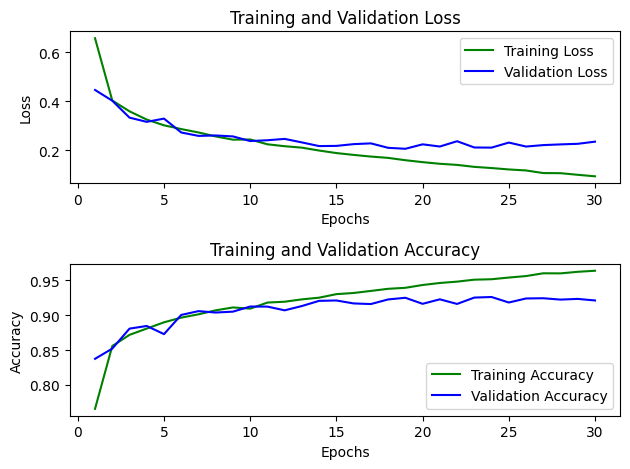

In [39]:
Trainer.plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [40]:
test_acc = trainer.evaluate()

Test Accuracy: 0.9157


# Your Task

Now, it's your turn to train a deep learning model. We will utilize the CIFAR-10 dataset available in the torchvision package. This dataset can be loaded by running the subsequent cell. You are required to configure the parameters for your model, select an optimizer and an learning rate, determine your batch size, and finally, present your results.

`Note`: Please pay attention to image shape, input/output of each layer

In [42]:
from torchvision.datasets import CIFAR10
(cifar_train, cifar_test) = [CIFAR10(root="data", train=train, download=True, 
                                     transform=Compose([ToTensor(), 
                                                        Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])) for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


In [43]:
train_loader = DataLoader(cifar_train, batch_size=256, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=256, shuffle=False)

In [47]:
class Net(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.dropout = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(in_features=64*8*8,out_features=128)
        self.fc2 = nn.Linear(in_features=128,out_features=num_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1,64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [45]:
cifar_train[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
netcifar10 = Net(input_channels=3, num_classes=10)
optimizer = Adam(netcifar10.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(netcifar10, train_loader, test_loader, test_loader, criterion, optimizer, device)
train_loss, train_acc, val_loss, val_acc = trainer.train(epochs=30, patience=10)